### 데이터

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
import os
import random
import numpy as np
import tensorflow as tf

main_seed = 1

os.environ['PYTHONHASHSEED']=str(main_seed)
random.seed(main_seed)
np.random.seed(main_seed)
tf.random.set_seed(main_seed)

# matplotlib 화질 설정
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1816478139.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


In [5]:
os.getcwd()

'C:\\Users\\82104\\HUFS_jupyter'

In [2]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [3]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, LSTM, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [30]:
# 데이터 불러오기
df = pd.read_excel('reach_data22.xlsx')
# df = df.drop(['Unnamed: 0'], axis=1)
df.head(3)

,Date,Store Number,Item number,Item name,Sales amount,Sale quantity,Unit of sale,"Total promotion based date,store and items",Promotionflag,Waste quantity,Inventory quantity
0,2017-10-27,3853,40270013,ELMA GOLDEN A KG,37.64,11.447,KG,182.54,0,0.0,44.629
1,2017-01-12,3349,10270350,MİGROS ANANAS ADET,41.93,7,AD,53.81,0,0.0,35
2,2017-08-23,607,33287429,CİPSLİK PATATES SELECT 2.5 KG AD.,11.95,2.5,AD,457.50,0,62.0,13


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22065 entries, 0 to 22064
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Date                                        22065 non-null  datetime64[ns]
 1   Store Number                                22065 non-null  int64         
 2   Item number                                 22065 non-null  int64         
 3   Item name                                   22065 non-null  object        
 4   Sales amount                                22065 non-null  float64       
 5   Sale quantity                               22065 non-null  object        
 6   Unit of sale                                22065 non-null  object        
 7   Total promotion based date,store and items  22065 non-null  float64       
 8   Promotionflag                               22065 non-null  int64         
 9   Waste 

In [32]:
data = df.copy()

In [45]:
data.drop(data[data['Inventory quantity'] == '********  '].index, inplace=True)
data.drop(data[data['Sale quantity'] == '********  '].index, inplace=True)

In [52]:
data.drop(['Item name'], axis=1, inplace=True)

In [53]:
data.head(3)

,Date,Store Number,Item number,Sales amount,Sale quantity,Unit of sale,"Total promotion based date,store and items",Promotionflag,Waste quantity,Inventory quantity
0,2017-10-27,3853,40270013,37.64,11.447,KG,182.54,0,0.0,44.629
1,2017-01-12,3349,10270350,41.93,7,AD,53.81,0,0.0,35
2,2017-08-23,607,33287429,11.95,2.5,AD,457.50,0,62.0,13


### Store Number 3853, 3349, 607이 각 Client가 되어 해당 일의 item 재고량을 예측 한다고 가정.  
#### Store 3853의 경우

In [58]:
# 그니까 얘가 따지고 보면 Client 1임
data_3853 = data[data['Store Number'] == 3853].reset_index(drop=True)
data_3853.head(3)

,Date,Store Number,Item number,Sales amount,Sale quantity,Unit of sale,"Total promotion based date,store and items",Promotionflag,Waste quantity,Inventory quantity
0,2017-10-27,3853,40270013,37.64,11.447,KG,182.54,0,0.00,44.629
1,2017-01-02,3853,20280029,4.79,1,KG,69.64,0,0.00,12.095
2,2017-01-28,3853,10270250,98.67,23.1,AD,2926.05,0,32.00,165
3,2017-11-25,3853,33288729,135.70,77.519,KG,510.48,0,0.00,152.254
4,2017-10-10,3853,10270350,133.78,22,AD,168.81,0,54.75,39
...,...,...,...,...,...,...,...,...,...,...
6906,2018-04-11,3853,281329,18.64,6.538,KG,700.07,0,72.20,13.494
6907,2018-08-20,3853,33288029,9.95,3,AD,82.76,0,28.20,4
6908,2018-07-20,3853,10270350,47.70,6,AD,497.02,0,0.00,84
6909,2018-12-09,3853,270358,11.97,3,AD,731.80,0,23.70,11


### 다변량을 어떻게 고려해야하지? 일단 당장은 생각이 안나서 Date별로 Item number 재고량을 작성해봄.

In [62]:
temp_3853 = pd.pivot_table(data_3853, values='Inventory quantity', index=['Date'], columns=['Item number'], aggfunc=np.sum).fillna(0)
temp_3853.columns = list(temp_3853.columns)
temp_3853.head(3)

,270340,270358,270413,270440,271113,273059,274413,280029,280129,280429,...,90272215,91271613,91273113,91273213,91273613,91276413,91277813,91287005,92274313,92274413
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,0.0,0.0
2017-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


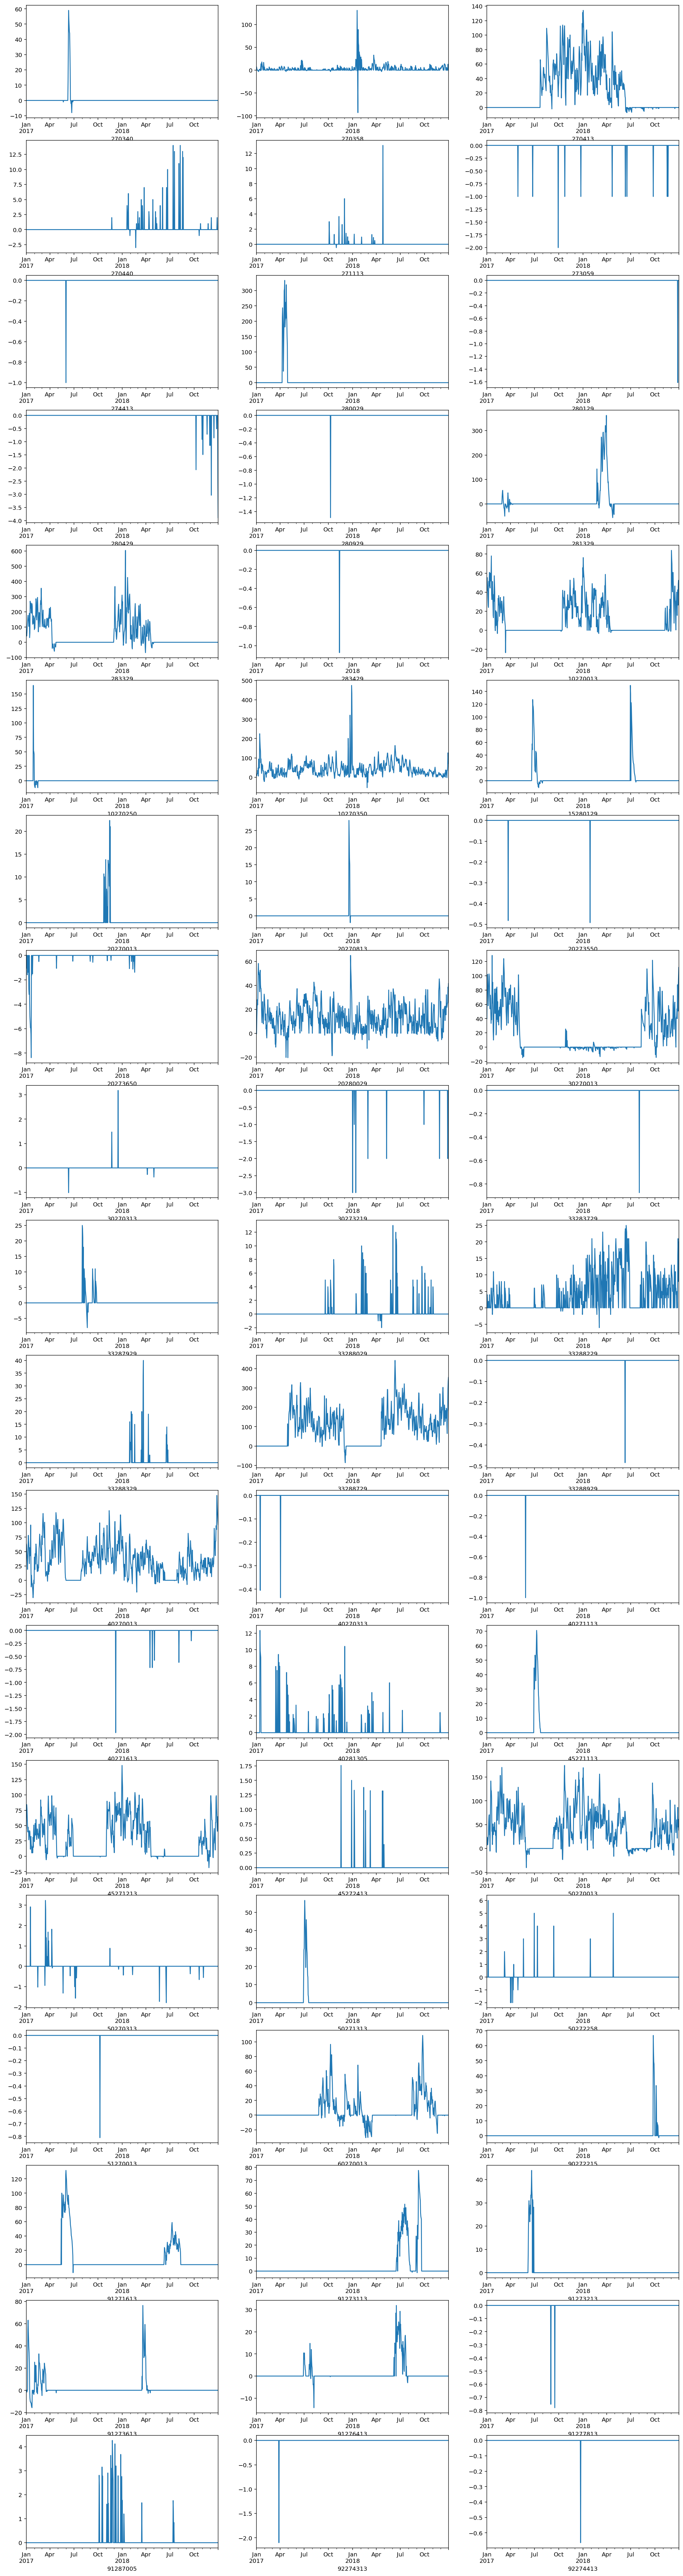

In [127]:
fig, axes = plt.subplots(nrows=19, ncols=3, figsize=(20, 80))
col_list = sorted(temp_3853.columns)

for row in range(19):
    for col in range(3):
        idx = row * 3 + col
        
        if idx < len(col_list):
            ax = axes[row][col]
            dept = col_list[idx]
            temp_3853[dept].plot(ax=ax)
            ax.set(xlabel=dept)

In [121]:
data['Item number'].value_counts()

10270350    2072
20280029    1957
40270013    1892
50270013    1802
270358      1358
            ... 
270313         1
33288429       1
92274413       1
40271113       1
92271513       1
Name: Item number, Length: 71, dtype: int64

In [ ]:
# Store Number 3349와 607도 살펴봄
data_3349 = data[data['Store Number'] == 3349].reset_index(drop=True)

temp_3349 = pd.pivot_table(data_3349, values='Inventory quantity', index=['Date'], columns=['Item number'], aggfunc=np.sum).fillna(0)
temp_3349.columns = list(temp_3349.columns)


data_607 = data[data['Store Number'] == 607].reset_index(drop=True)

temp_607 = pd.pivot_table(data_607, values='Inventory quantity', index=['Date'], columns=['Item number'], aggfunc=np.sum).fillna(0)
temp_607.columns = list(temp_607.columns)

In [152]:
print(len(temp_3853),len(temp_3349),len(temp_607))

730 729 730


In [157]:
set(temp_3853.index)^set(temp_3349.index)

{Timestamp('2017-09-01 00:00:00')}

In [158]:
new_idx = pd.date_range(temp_3349.index.min(), temp_3349.index.max())
print(new_idx)

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=730, freq='D')


In [167]:
temp_3349 = temp_3349.reindex(new_idx)
temp_3349[temp_3349.index== '2017-09-01 00:00:00'] = 0
temp_3349[temp_3349.index== '2017-09-01 00:00:00']

,270340,270358,270413,273059,280029,281329,283329,10270013,10270250,10270350,...,50270013,50271313,50272258,60270013,91271113,91271613,91273113,91273213,91273613,91276413
2017-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


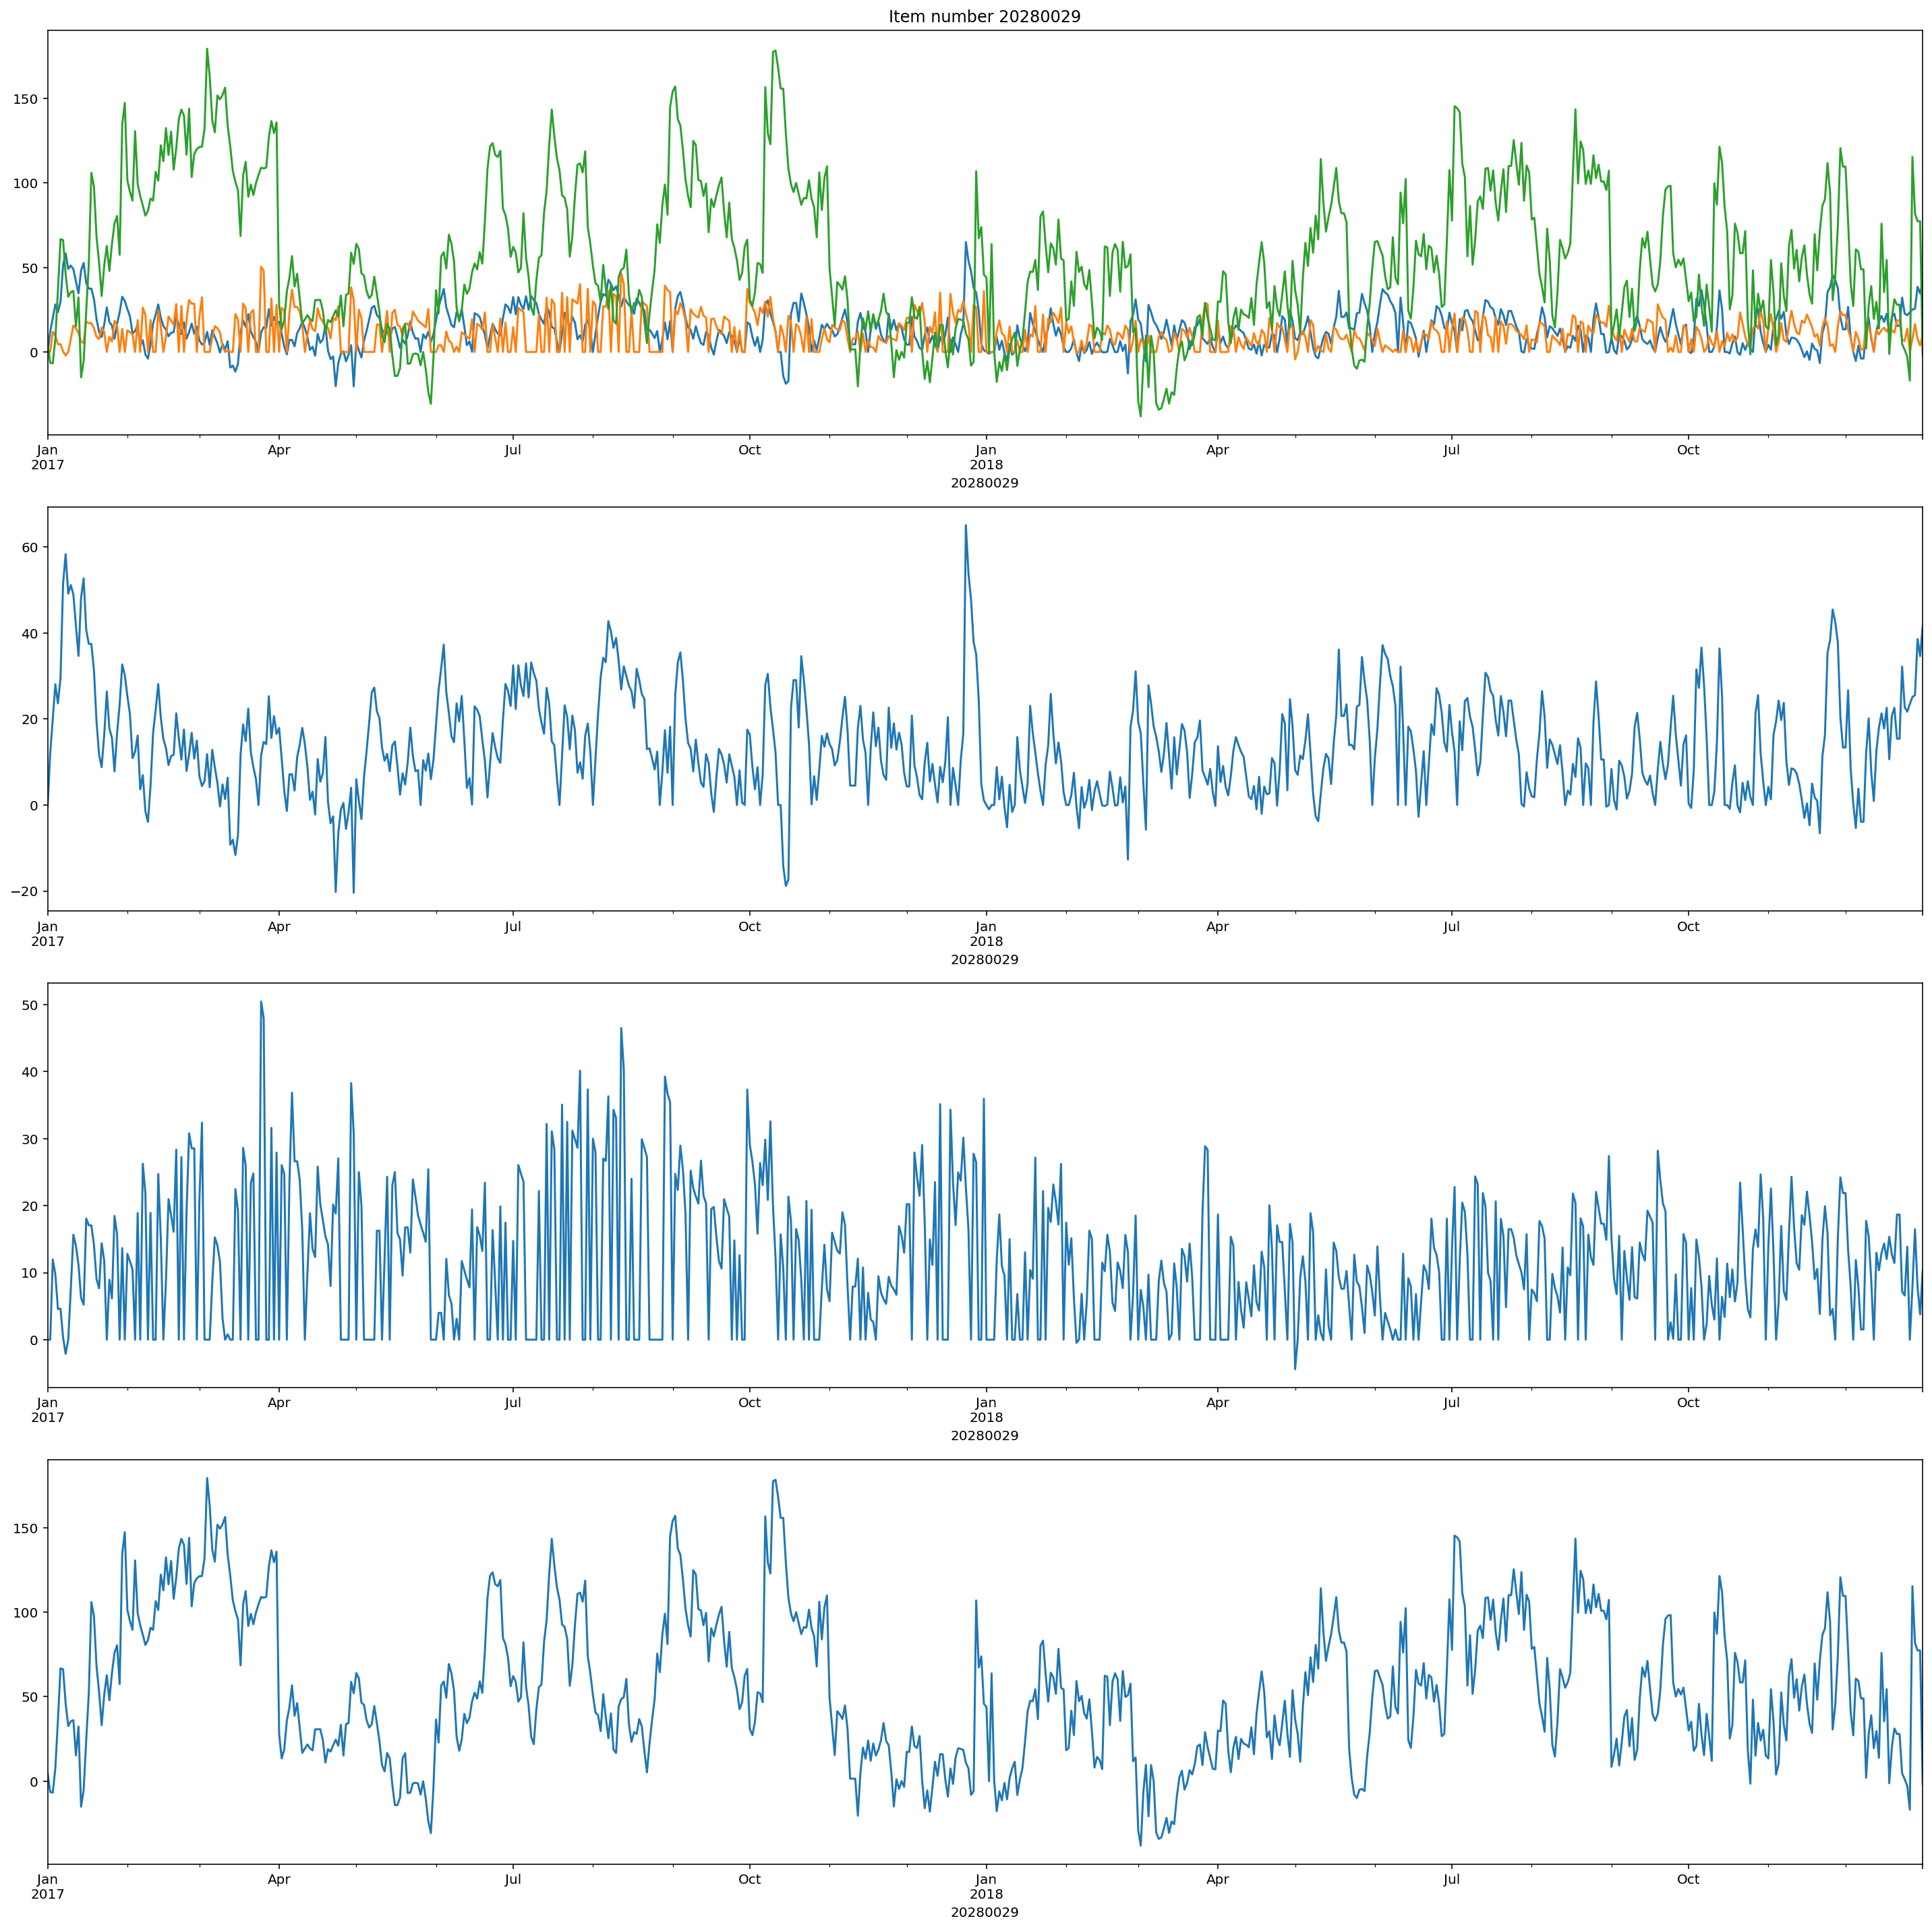

In [168]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20))

axes[0].title.set_text("Item number 20280029")
temp_3853[20280029].plot(xlabel=20280029, ax=axes[0])
temp_3349[20280029].plot(xlabel=20280029, ax=axes[0])
temp_607[20280029].plot(xlabel=20280029, ax=axes[0])


temp_3853[20280029].plot(xlabel=20280029, ax=axes[1])
temp_3349[20280029].plot(xlabel=20280029, ax=axes[2])
temp_607[20280029].plot(xlabel=20280029, ax=axes[3])

fig.tight_layout()
plt.show()

### 그니까 대충 Item number들 중에서 그나마 해볼만한 Item number가 20280029

In [ ]:
# 빈 날짜 목록 생성
temp_3853_index = set(temp_3853.index)
need = day_list - temp_cat_index
print(len(need))

# 빈 날짜의 수요량은 0로 채우기
for idx in list(need):
    temp_cat.loc[idx] = 0

temp_cat = temp_cat.sort_index()

print(temp_cat.shape)

In [199]:
cat_20280029 = temp_3853[[20280029]]
cat_20280029 = cat_20280029.reset_index()
cat_20280029.columns = ['Date', 'Inventory quantity']

print(cat_20280029.shape)
cat_20280029.head()

(730, 2)


,Date,Inventory quantity
0,2017-01-01,-0.405
1,2017-01-02,12.095
2,2017-01-03,20.180
3,2017-01-04,28.090
4,2017-01-05,23.630


In [173]:
# lag 생성 => 대충 한달 잡음
for num in range(1, 31):
    cat_20280029['t-'+str(num)] = cat_20280029['Invenotry quantity'].shift(num)

In [174]:
# 다 nan인 row(맨 위에 있는 row)
cat_20280029 = cat_20280029.drop(0).reset_index(drop=True)

In [176]:
# train, validation dataset
train_lag = cat_20280029[cat_20280029['Date'] < '2018-08-01']
val_lag = cat_20280029[cat_20280029['Date'] >= '2018-08-01']

In [178]:
# feature matrix, target vector
X_train_lag = train_lag.drop(['Date', 'Invenotry quantity'], axis=1)
y_train = train_lag['Invenotry quantity']

X_val_lag = val_lag.drop(['Date', 'Invenotry quantity'], axis=1)
y_val = val_lag['Invenotry quantity']

In [179]:
# 확인
print(X_train_lag.shape, y_train.shape)
print(X_val_lag.shape, y_val.shape)
X_train_lag.head(3)

(576, 30) (576,)
(153, 30) (153,)


,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,...,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30
0,-0.405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12.095,-0.405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20.180,12.095,-0.405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [180]:
# 결과 정리를 위한 dataframe 생성
result_df = pd.DataFrame({
    'lag': [],
    'lstm': [],
    'fc': [],
    'mae': [],
    'rmse': []
})
result_df

,lag,lstm,fc,mae,rmse


In [182]:
def create_model(time_stpes=29, n_lstm=1, n_fc=1):
    model = Sequential()
    model.add(Reshape((time_stpes, 1), input_shape=(time_stpes,))) # 3차원으로

    # lstm layer 추가 (1 ~ n번째)
    for _ in range(0, n_lstm-1):
        model.add(LSTM(32, activation='relu',
                       kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                       recurrent_initializer=initializers.orthogonal(seed=main_seed),
                       return_sequences=True))

    model.add(LSTM(32, activation='relu', 
                   kernel_initializer=initializers.glorot_uniform(seed=main_seed),
                   recurrent_initializer=initializers.orthogonal(seed=main_seed)))

    # fc layer 추가
    for _ in range(1, n_fc+1):
        model.add(Dense(32, activation='relu',
                        kernel_initializer=initializers.glorot_normal(seed=main_seed)))


    # output layer
    model.add(Dense(1, kernel_initializer=initializers.glorot_normal(seed=main_seed)))

    model.compile(optimizer='adam',
                loss='mae',
                metrics=['mae', 'mse'])
    return model

In [190]:
order_list = [(1, 1), (2, 1), (3, 1)]
order_list

[(1, 1), (2, 1), (3, 1)]

In [191]:
for num in range(1, 31):
    print(f'time_steps: {num} --------------')

    for n_lstm, n_fc in order_list:
        print(f'lstm: {n_lstm}개, fc: {n_fc}개')

        # 모델 생성
        reg = KerasRegressor(
            build_fn=create_model,
            time_stpes=num,
            n_lstm=n_lstm,
            n_fc=n_fc,
            batch_size=32,
            epochs=10,
            verbose=0,
            validation_data=(X_val_lag.iloc[:, :num], y_val))

        # 파이프라인
        pipeline = make_pipeline(
            SimpleImputer(),
            RobustScaler(),
            reg)

        # 학습
        pipeline.fit(
            X_train_lag.iloc[num-1:, :num],
            y_train[X_train_lag.iloc[num-1:, :num].index])

        # 예측
        y_pred = pipeline.predict(X_val_lag.iloc[:, :num])

        # 결과 정리
        new_row = {'lag':num,
                   'lstm': n_lstm,
                   'fc': n_fc,
                  'mae':round(mae(y_val, y_pred), 2),
                  'rmse':round(np.sqrt(mse(y_val, y_pred)), 2)}
        
        result_df = result_df.append(new_row, ignore_index=True)

time_steps: 1 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 2 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 3 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 4 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 5 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 6 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 7 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 8 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 9 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 10 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 11 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개
time_steps: 12 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.ad

lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 13 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 14 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 15 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 16 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 17 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 18 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 19 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 20 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 21 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 22 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 23 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 24 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 25 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 26 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 27 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 28 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 29 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


time_steps: 30 --------------
lstm: 1개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 2개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)
C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


lstm: 3개, fc: 1개


C:\Users\82104\AppData\Local\Temp\ipykernel_27504\1010057910.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(new_row, ignore_index=True)


In [192]:
result_df.head()

,lag,lstm,fc,mae,rmse
0,1.0,1.0,1.0,7.68,10.16
1,1.0,1.0,2.0,6.35,7.88
2,1.0,1.0,3.0,6.26,7.92
3,1.0,2.0,1.0,6.45,8.03
4,1.0,2.0,2.0,6.44,8.01


In [196]:
result_df.to_csv('result_0718.csv')

## 결과

In [194]:
# 상위 5개 (rmse가 작은 순)
result_df.sort_values(by='rmse').head(10)

,lag,lstm,fc,mae,rmse
1,1.0,1.0,2.0,6.35,7.88
2,1.0,1.0,3.0,6.26,7.92
5,1.0,2.0,3.0,6.42,7.94
4,1.0,2.0,2.0,6.44,8.01
8,1.0,3.0,3.0,6.50,8.01
3,1.0,2.0,1.0,6.45,8.03
125,1.0,2.0,1.0,6.45,8.03
6,1.0,3.0,1.0,6.51,8.07
7,1.0,3.0,2.0,6.53,8.07
126,1.0,3.0,1.0,6.51,8.07


In [195]:
# 하위 5개
result_df.sort_values(by='rmse').tail(10)

,lag,lstm,fc,mae,rmse
196,25.0,1.0,1.0,8.53,10.91
199,26.0,1.0,1.0,8.59,10.94
193,24.0,1.0,1.0,8.65,10.94
205,28.0,1.0,1.0,8.57,10.94
207,28.0,3.0,1.0,8.70,10.96
210,29.0,3.0,1.0,8.68,11.00
212,30.0,2.0,1.0,8.61,11.01
198,25.0,3.0,1.0,8.60,11.11
211,30.0,1.0,1.0,8.70,11.18
213,30.0,3.0,1.0,8.71,11.22


In [197]:
# 가장 성능이 좋은 모델 (mae가 가장 작은 모델) 예측 결과 시각화
num=1
n_lstm=1
n_fc=1

reg = KerasRegressor(
    build_fn=create_model,
    time_stpes=num,
    n_lstm=n_lstm,
    n_fc=n_fc,
    batch_size=32,
    epochs=10,
    verbose=0,
    validation_data=(X_val_lag.iloc[:, :num], y_val))

# 파이프라인
pipeline = make_pipeline(
    SimpleImputer(),
    RobustScaler(),
    reg)

# 학습
pipeline.fit(
    X_train_lag.iloc[num-1:, :num],
    y_train[X_train_lag.iloc[num-1:, :num].index])

# 예측
y_pred = pipeline.predict(X_val_lag.iloc[:, :num])



C:\Users\82104\AppData\Local\Temp\ipykernel_27504\80064668.py:6: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg = KerasRegressor(


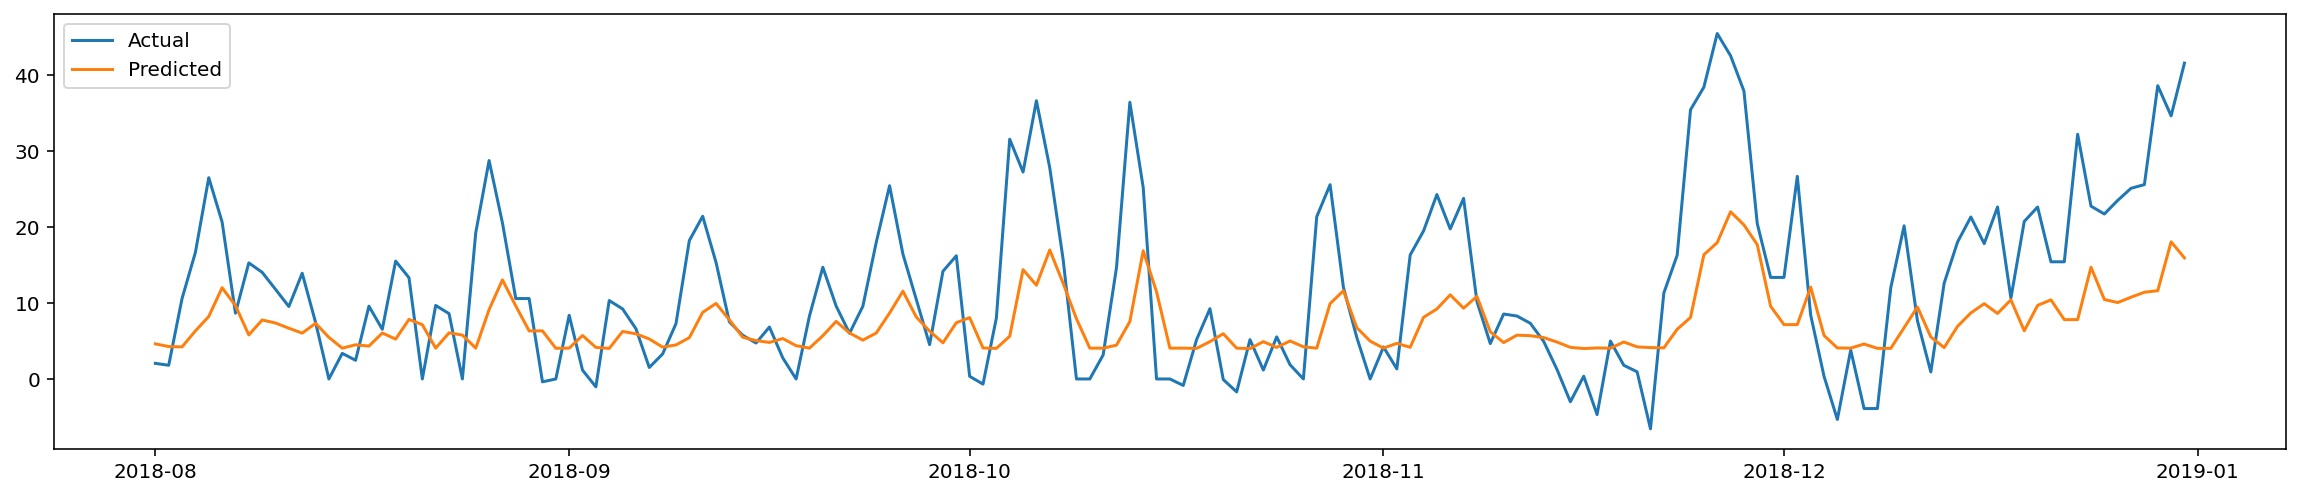

In [206]:
# 그래프 그리기
plt.figure(figsize=(20, 4))
plt.plot(cat_20280029[cat_20280029['Date'] >= '2018-08-01']['Date'], cat_20280029[cat_20280029['Date'] >= '2018-08-01']['Inventory quantity'], label='Actual')
plt.plot(cat_20280029[cat_20280029['Date'] >= '2018-08-01']['Date'], y_pred, label='Predicted')
plt.legend()

plt.show();